# 数据准备

In [8]:
!wget https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt

--2025-07-07 12:41:29--  https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.207, 74.125.130.207, 74.125.68.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘shakespeare.txt.1’

shakespeare.txt.1   100%[===================>]   1.06M  1.06MB/s    in 1.0s    

2025-07-07 12:41:30 (1.06 MB/s) - ‘shakespeare.txt.1’ saved [1115394/1115394]



In [9]:
import os
import numpy as np
import tensorflow as tf

# 读取Shakespeare文本文件
with open('shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# 打印文本的前100个字符
print(f"文本长度: {len(text)}")
print(f"文本前100个字符:\n{text[:100]}")

# 创建字符级别的字典
vocab = sorted(set(text))
print(f"字典大小: {len(vocab)}")
print(f"字典内容: {vocab}")

# 创建字符到索引的映射
char_to_idx = {char: idx for idx, char in enumerate(vocab)}
idx_to_char = {idx: char for idx, char in enumerate(vocab)}

# 打印映射示例
print("\n字符到索引的映射示例:")
for char in text[:20]:
    print(f"'{char}' -> {char_to_idx[char]}")

# 将文本转换为数字序列
text_as_int = np.array([char_to_idx[c] for c in text]) #把全部文本都变为id
print(f"\n文本转换为数字序列的前20个元素:\n{text_as_int[:20]}")
print(f"将数字序列转回字符:\n{''.join([idx_to_char[idx] for idx in text_as_int[:20]])}")


文本长度: 1115394
文本前100个字符:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You
字典大小: 65
字典内容: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

字符到索引的映射示例:
'F' -> 18
'i' -> 47
'r' -> 56
's' -> 57
't' -> 58
' ' -> 1
'C' -> 15
'i' -> 47
't' -> 58
'i' -> 47
'z' -> 64
'e' -> 43
'n' -> 52
':' -> 10
'
' -> 0
'B' -> 14
'e' -> 43
'f' -> 44
'o' -> 53
'r' -> 56

文本转换为数字序列的前20个元素:
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56]
将数字序列转回字符:
First Citizen:
Befor


# 把莎士比亚文集分成一个一个的样本

In [10]:
# 定义序列长度和批次大小
import torch
from torch.utils.data import Dataset, DataLoader

seq_length = 100  # 每个样本的序列长度
batch_size = 64   # 每个批次的样本数量

# 创建自定义数据集类
class ShakespeareDataset(Dataset):
    def __init__(self, text_as_int, seq_length):
        self.text_as_int = text_as_int
        self.seq_length = seq_length
        self.sub_len = seq_length + 1 #一个样本的长度

    def __len__(self):
        # 计算可能的序列数量
        return len(self.text_as_int)//(self.seq_length+1) #+1是因为要预测下一个字符

    def __getitem__(self, idx):
        # 将numpy数组转换为长整型(Long)
        return torch.tensor(self.text_as_int[idx*self.sub_len:(idx+1)*self.sub_len], dtype=torch.long)

# 定义collate函数，用于处理批次数据
def collate_fct(batch):
    # 将批次数据堆叠成张量，确保类型为long
    batch = torch.stack(batch)
    # 输入序列是除了最后一个字符的所有字符
    input_batch = batch[:, :-1]
    # 目标序列是除了第一个字符的所有字符
    target_batch = batch[:, 1:]
    return input_batch, target_batch

# 创建数据集实例
shakespeare_dataset = ShakespeareDataset(text_as_int, seq_length)

# 创建数据加载器
dataloader = DataLoader(shakespeare_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=collate_fct)

# 打印示例，查看输入和目标
for input_batch, target_batch in dataloader:
    print(f"输入批次形状: {input_batch.shape}")
    print(f"目标批次形状: {target_batch.shape}")

    # 打印第一个样本的输入和目标
    print(input_batch)
    print(target_batch)
    break

print(f"\n数据集大小: {len(shakespeare_dataset)}")
print(f"批次数量: {len(dataloader)}")


输入批次形状: torch.Size([64, 100])
目标批次形状: torch.Size([64, 100])
tensor([[ 1, 58, 53,  ..., 58, 43, 56],
        [ 0, 58, 46,  ..., 43, 39, 56],
        [ 1, 39,  1,  ..., 61, 47, 50],
        ...,
        [49, 43, 42,  ..., 47, 50,  8],
        [ 1, 61, 46,  ..., 56, 47, 52],
        [45,  1, 39,  ..., 52, 58, 53]])
tensor([[58, 53,  1,  ..., 43, 56, 10],
        [58, 46, 47,  ..., 39, 56, 43],
        [39,  1, 58,  ..., 47, 50, 50],
        ...,
        [43, 42,  1,  ..., 50,  8,  0],
        [61, 46, 47,  ..., 47, 52, 47],
        [ 1, 39, 58,  ..., 58, 53,  1]])

数据集大小: 11043
批次数量: 172


In [11]:
11043//64

172

# 搭建模型

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# 定义LSTM模型
class ShakespeareLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size):
        super(ShakespeareLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=1,
            bidirectional=False,
            batch_first=True
        )
        self.dense = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        # 输入形状: [batch_size, sequence_length]
        x = self.embedding(x)  # 形状: [batch_size, sequence_length, embedding_dim]
        output, hidden = self.lstm(x, hidden)  # 形状: [batch_size, sequence_length, hidden_dim]
        output = self.dense(output)  # 形状: [batch_size, sequence_length, vocab_size]
        return output, hidden



# 定义模型参数
vocab_size = len(char_to_idx)  # 词汇表大小
embedding_dim = 256  # 嵌入维度
lstm_units = 1024  # LSTM单元数量

# 实例化模型
model = ShakespeareLSTM(vocab_size, embedding_dim, lstm_units, batch_size)
print(model)


ShakespeareLSTM(
  (embedding): Embedding(65, 256)
  (lstm): LSTM(256, 1024, batch_first=True)
  (dense): Linear(in_features=1024, out_features=65, bias=True)
)


In [13]:
# 创建一个小批量数据来测试模型
batch_size = 4
seq_length = 100
test_input = torch.randint(0, vocab_size, (batch_size, seq_length))

# 进行前向计算
with torch.no_grad():
    output, hidden = model(test_input)

# 打印输出形状
print(f"输入形状: {test_input.shape}")
print(f"输出形状: {output.shape}")

# 验证输出是否符合预期
assert output.shape == (batch_size, seq_length, vocab_size), "输出形状不符合预期"

print("模型前向计算验证成功！")


输入形状: torch.Size([4, 100])
输出形状: torch.Size([4, 100, 65])
模型前向计算验证成功！


# 训练

In [14]:
from tqdm.auto import tqdm
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练函数
def train_step(model, dataloader, optimizer, criterion, epochs=5):
    losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        # 使用tqdm创建进度条
        with tqdm(dataloader, desc=f"轮次 {epoch+1}/{epochs}") as pbar:
            for input_batch, target_batch in pbar:
                input_batch = input_batch.to(device)
                target_batch = target_batch.to(device)
                optimizer.zero_grad()

                # 前向传播
                output, _ = model(input_batch)

                # 计算损失
                # 重塑输出和目标以适应CrossEntropyLoss
                output = output.reshape(-1, vocab_size)
                target_batch = target_batch.reshape(-1)

                loss = criterion(output, target_batch)

                # 反向传播
                loss.backward()
                optimizer.step()

                current_loss = loss.item()
                epoch_loss += current_loss

                # 更新进度条显示的损失值
                pbar.set_postfix({"损失": f"{current_loss:.4f}"})

        # 计算并记录每个epoch的平均损失
        avg_epoch_loss = epoch_loss / len(dataloader)
        losses.append(avg_epoch_loss)
        print(f"轮次 {epoch+1}/{epochs} 完成, 平均损失: {avg_epoch_loss:.4f}")

    return losses

# 将模型移动到设备上
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 开始训练循环
losses = train_step(model, dataloader, optimizer, criterion, epochs=5)


轮次 1/5:   0%|          | 0/172 [00:00<?, ?it/s]

轮次 1/5 完成, 平均损失: 2.0611


轮次 2/5:   0%|          | 0/172 [00:00<?, ?it/s]

轮次 2/5 完成, 平均损失: 1.5395


轮次 3/5:   0%|          | 0/172 [00:00<?, ?it/s]

轮次 3/5 完成, 平均损失: 1.4134


轮次 4/5:   0%|          | 0/172 [00:00<?, ?it/s]

轮次 4/5 完成, 平均损失: 1.3447


轮次 5/5:   0%|          | 0/172 [00:00<?, ?it/s]

轮次 5/5 完成, 平均损失: 1.2943


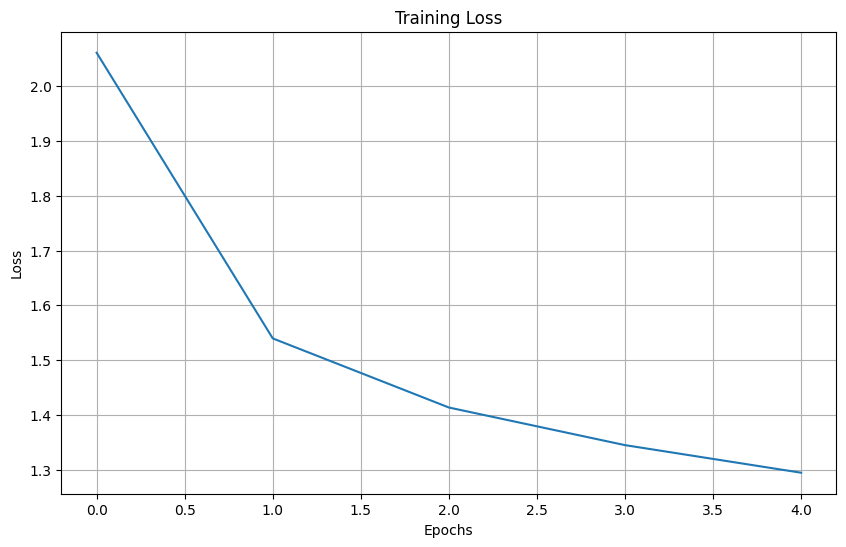

In [15]:
import matplotlib.pyplot as plt
# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [16]:
# 理解torch.multinomial函数的小例子
import torch
import torch.nn.functional as F

# 创建一个概率分布
probs = torch.tensor([0.1, 0.2, 0.3, 0.4])
print("概率分布:", probs)

# 从概率分布中采样一个元素
sample = torch.multinomial(probs, num_samples=1)
print("采样一个元素:", sample.item(), "对应概率:", probs[sample.item()].item())



概率分布: tensor([0.1000, 0.2000, 0.3000, 0.4000])
采样一个元素: 0 对应概率: 0.10000000149011612


原始logits值: tensor([1.0000, 2.0000, 5.0000, 3.0000, 0.5000])

temperature=0.5时的概率分布:
tensor([3.2848e-04, 2.4272e-03, 9.7919e-01, 1.7934e-02, 1.2084e-04])

temperature=1.0时的概率分布:
tensor([0.0151, 0.0410, 0.8234, 0.1114, 0.0091])

temperature=2.0时的概率分布:
tensor([0.0739, 0.1218, 0.5459, 0.2008, 0.0575])


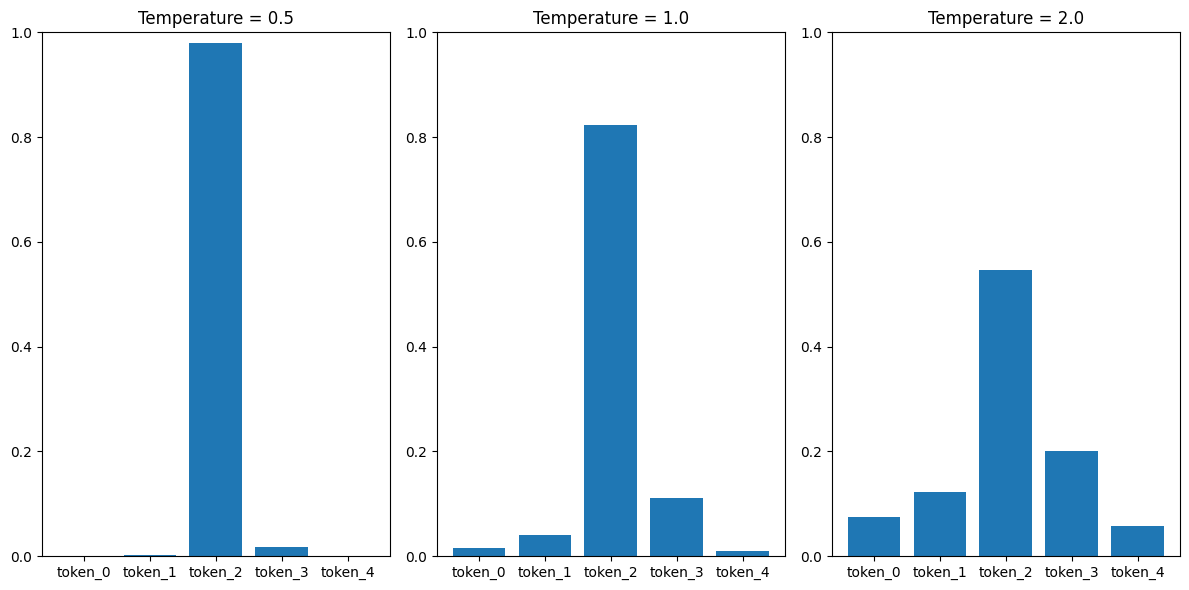


解释:
- 较低的temperature (如0.5) 使概率分布更加尖锐，最高概率的token被选中的可能性更大
- 标准temperature (1.0) 保持原始概率分布
- 较高的temperature (如2.0) 使概率分布更加平坦，增加了采样的随机性


In [17]:
# 展示temperature参数对softmax输出的影响
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 创建一个模拟的logits输出
logits = torch.tensor([1.0, 2.0, 5.0, 3.0, 0.5])
print("原始logits值:", logits)

# 使用不同的temperature值
temperatures = [0.5, 1.0, 2.0]

plt.figure(figsize=(12, 6))

for i, temp in enumerate(temperatures):
    # 应用temperature
    scaled_logits = logits / temp

    # 应用softmax获取概率分布
    probabilities = F.softmax(scaled_logits, dim=0)

    # 打印结果
    print(f"\ntemperature={temp}时的概率分布:")
    print(probabilities)

    # 可视化
    plt.subplot(1, len(temperatures), i+1)
    plt.bar(range(len(probabilities)), probabilities.numpy())
    plt.title(f"Temperature = {temp}")
    plt.ylim(0, 1)
    plt.xticks(range(len(probabilities)), [f"token_{i}" for i in range(len(probabilities))])

plt.tight_layout()
plt.show()

print("\n解释:")
print("- 较低的temperature (如0.5) 使概率分布更加尖锐，最高概率的token被选中的可能性更大")
print("- 标准temperature (1.0) 保持原始概率分布")
print("- 较高的temperature (如2.0) 使概率分布更加平坦，增加了采样的随机性")


In [18]:
# 生成文本函数
def generate_text(model, start_string, char2idx, idx2char, num_generate=1000, temperature=1.0):
    # 将模型设置为评估模式
    model.eval()

    # 将起始字符串转换为索引
    input_indices = [char2idx[char] for char in start_string]
    input_tensor = torch.tensor(input_indices, dtype=torch.long).unsqueeze(0).to(device) #unsqueeze(0) 在第0维上增加一个维度
    print(input_tensor.shape)
    # 存储生成的文本
    generated_text = start_string

    # 隐藏状态初始化为None，模型会自动初始化
    hidden = None

    # 生成指定数量的字符
    with torch.no_grad():
        for _ in range(num_generate):
            # 获取模型预测
            output, hidden = model(input_tensor,hidden)

            # 应用温度参数调整预测分布
            logits = output[:, -1, :] / temperature

            # 从调整后的分布中采样下一个字符
            probabilities = F.softmax(logits, dim=-1)
            predicted_id = torch.multinomial(probabilities, 1) #从概率分布中采样一个元素，概率越大，被选中的可能性越大

            # 将预测的字符添加到生成文本中
            generated_char = idx2char[predicted_id.item()]
            generated_text += generated_char #放入到生成序列

            # 更新输入张量为当前预测的字符
            input_tensor = predicted_id

    return generated_text

generate_text(model, 'hello',char_to_idx,idx_to_char)

torch.Size([1, 5])


"hellow by my mind.\n\nCORIOLANUS:\nThere is banish'd, sir, take, charging overly joy\nAs best unmade many taken too to the sleep,\nAnd care thy name of Gloucester's hole none!\n\nHERMIONE:\nThat I will not believe him held.\n\nSecond Puy:\nWell, no, sir; for I am rise\nBut to the battle of your sword:\nOne to angel of blood of his own mistress\nTo this love--\n\nROMEO:\nAs good my look, ho! Now it believed go in gentles.\nthe pluck-hold myself; by which comes redual there.\n\nBUCKINGHAM:\nI will none can non and blames,\nTo single beauty.\n\nGREEMIO:\nTell me after good living earthly mad!\n\nALONSO:\nUnder looks he must be world\nI have, while move continuamn's medire\nHe odd for setility he that my Romeo is.\n\nBAPTISTA:\nTillon'd friar, some trades of my prize to the feagel's\nbove, that not thus. 'Tis well we have I thank a boyt\nAnd who, he shall be suddenly longer blunt.\nI go, and by his kity: what you would\nemberity;\nAnd when there is Prince, and inturous.\n\nKING HENRY VI:\